In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import (
    Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block, plot_ordered_matrix, pivot_resdf
)
from bold_dementia.utils.iterables import unique
import networkx as nx
from bold_dementia.visualisation.chord_plot import create_chord, make_links

ATLAS = "msdl"
SOFT = False
ALPHA = config["alpha"]
atlas = Atlas.from_name(ATLAS, soft=SOFT)


In [2]:
expname = f"atlas-{ATLAS}_merged_ols-cenanom-block"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)
resdf = pd.read_csv(matrices_path / "resdf.csv", index_col=0)
resdf_pv = pivot_resdf(resdf, alpha=ALPHA)

In [3]:
resdf

,edges,beta_AD,pvalues_raw,pvalues_fdr,node_a,node_b,thresholded_beta
0,Ant IPS_Ant IPS,-0.031943,0.125930,0.291929,Ant IPS,Ant IPS,-0.0
1,Ant IPS_Aud,-0.018405,0.360396,0.557649,Ant IPS,Aud,-0.0
2,Aud_Aud,-0.059933,0.013589,0.071694,Aud,Aud,-0.0
3,Ant IPS_Basal,0.037568,0.033689,0.132163,Ant IPS,Basal,0.0
4,Aud_Basal,0.053679,0.008159,0.055792,Aud,Basal,0.0
...,...,...,...,...,...,...,...
148,R V Att_Vis Sec,0.033120,0.008571,0.055792,R V Att,Vis Sec,0.0
149,Salience_Vis Sec,-0.004473,0.763962,0.895712,Salience,Vis Sec,-0.0
150,Striate_Vis Sec,-0.036418,0.090956,0.239195,Striate,Vis Sec,-0.0
151,Temporal_Vis Sec,-0.046906,0.009481,0.055792,Temporal,Vis Sec,-0.0


In [4]:
minidf = resdf.loc[:, ["node_a", "node_b", "thresholded_beta"]]
minidf = minidf.rename({"thresholded_beta": "weight"}, axis=1)

In [5]:
minidf[minidf.weight != 0]

,node_a,node_b,weight
16,Aud,D Att,-0.050806
20,D Att,D Att,-0.061454
39,Cereb,L V Att,-0.040637
41,D Att,L V Att,-0.040152
43,Dors PCC,L V Att,0.049244
54,Language,Language,-0.044353
69,Cereb,Occ post,0.075743
86,L V Att,R V Att,-0.032161
90,R V Att,R V Att,-0.045702
94,Cereb,Salience,-0.054236


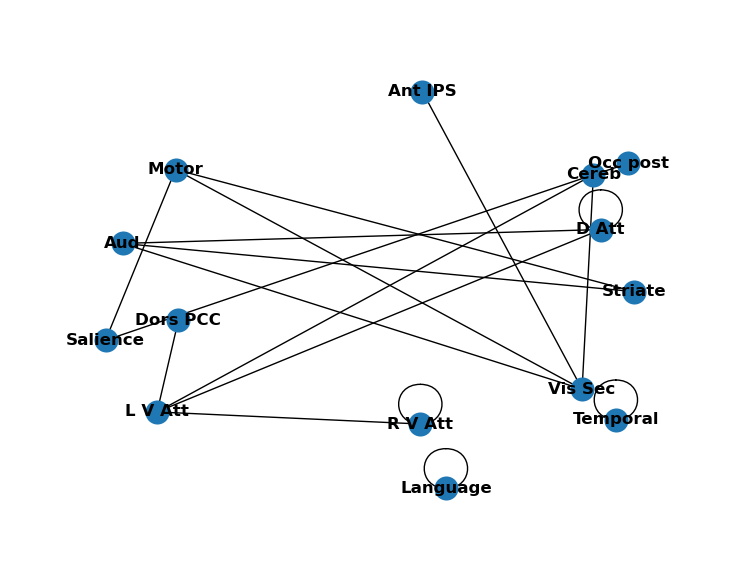

In [6]:
G = nx.from_pandas_edgelist(
    minidf[minidf.weight != 0],
    source="node_a",
    target="node_b",
    edge_attr="weight"
)

nx.draw(G, with_labels=True, font_weight='bold')

plt.show()



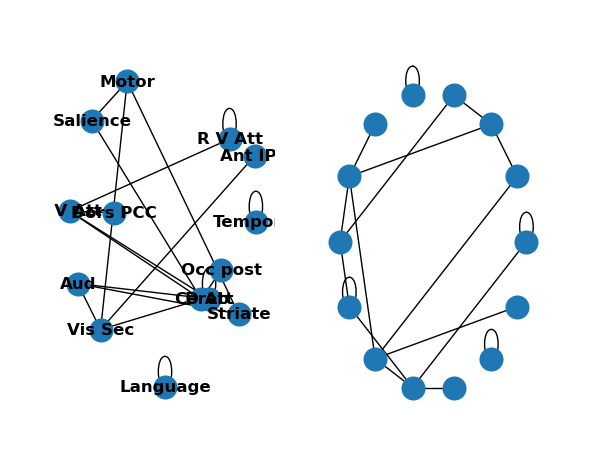

In [7]:
import matplotlib.pyplot as plt
subax1 = plt.subplot(121)

nx.draw(G, with_labels=True, font_weight='bold')

subax2 = plt.subplot(122)

nx.draw_shell(G)

In [9]:
matrix_df = resdf_pv["thresholded_beta"]
matrix_df.fillna(value=0, inplace=True)
labels = atlas.labels_

links = make_links(matrix_df)

Ant IPS Vis Sec -0.0708468995997903 0.708468995997903
Aud D Att -0.0508062249379078 0.508062249379078
Aud Striate -0.0845617436514067 0.845617436514067
Aud Vis Sec -0.0763936343543281 0.763936343543281
Cereb L V Att -0.0406374087585605 0.406374087585605
Cereb Occ post 0.0757430690788761 0.7574306907887609
Cereb Salience -0.0542355286604889 0.542355286604889
Cereb Vis Sec 0.0930471967197065 0.930471967197065
D Att D Att -0.0614537386058297 0.614537386058297
D Att L V Att -0.0401523659808277 0.401523659808277
Dors PCC L V Att 0.0492438188853651 0.49243818885365104
L V Att R V Att -0.0321607598082751 0.32160759808275097
Language Language -0.0443527656198551 0.443527656198551
Motor Salience 0.0685854438857669 0.6858544388576691
Motor Striate -0.0899394807741162 0.899394807741162
Motor Vis Sec -0.0858439352132204 0.858439352132204
R V Att R V Att -0.0457020671738589 0.45702067173858896
Temporal Temporal -0.0712270980408518 0.712270980408518


/tmp/ipykernel_3993284/3292383927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df.fillna(value=0, inplace=True)


In [10]:
links

[(('Ant IPS', 4.645765502001049, 5.354234497998951),
  ('Vis Sec', 4.645765502001049, 5.354234497998951),
  'blue'),
 (('Aud', 4.745968875310461, 5.254031124689539),
  ('D Att', 4.745968875310461, 5.254031124689539),
  'blue'),
 (('Aud', 4.577191281742967, 5.422808718257033),
  ('Striate', 4.577191281742967, 5.422808718257033),
  'blue'),
 (('Aud', 4.61803182822836, 5.38196817177164),
  ('Vis Sec', 4.61803182822836, 5.38196817177164),
  'blue'),
 (('Cereb', 4.796812956207198, 5.203187043792802),
  ('L V Att', 4.796812956207198, 5.203187043792802),
  'blue'),
 (('Cereb', 4.62128465460562, 5.37871534539438),
  ('Occ post', 4.62128465460562, 5.37871534539438),
  'red'),
 (('Cereb', 4.728822356697555, 5.271177643302445),
  ('Salience', 4.728822356697555, 5.271177643302445),
  'blue'),
 (('Cereb', 4.534764016401468, 5.465235983598532),
  ('Vis Sec', 4.534764016401468, 5.465235983598532),
  'red'),
 (('D Att', 0, 0.614537386058297), ('D Att', 9.385462613941703, 10), 'blue'),
 (('D Att', 4.79

Text(0.5, 1.01, 'atlas-msdl_merged_ols-cenanom-block\nTresholded slopes ($\\alpha = $0.05, FDR corrected)')

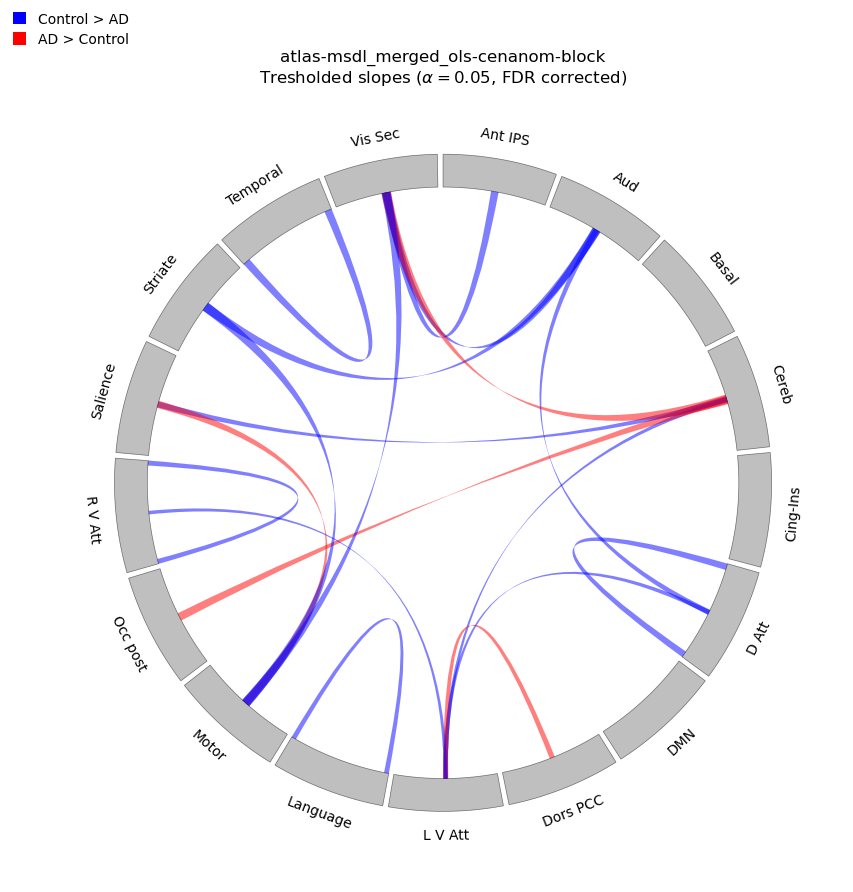

In [11]:
import matplotlib.patches as mpatches

blue_patch = mpatches.Patch(color='blue', label='Control > AD')
red_patch = mpatches.Patch(color='red', label='AD > Control')

networks = matrix_df.columns.to_list()
fig = create_chord(networks, links)
fig.legend(handles=[blue_patch, red_patch])
fig.suptitle(
    f"{expname}\nTresholded slopes ($\\alpha = ${ALPHA}, FDR corrected)",
    y=1.01
)

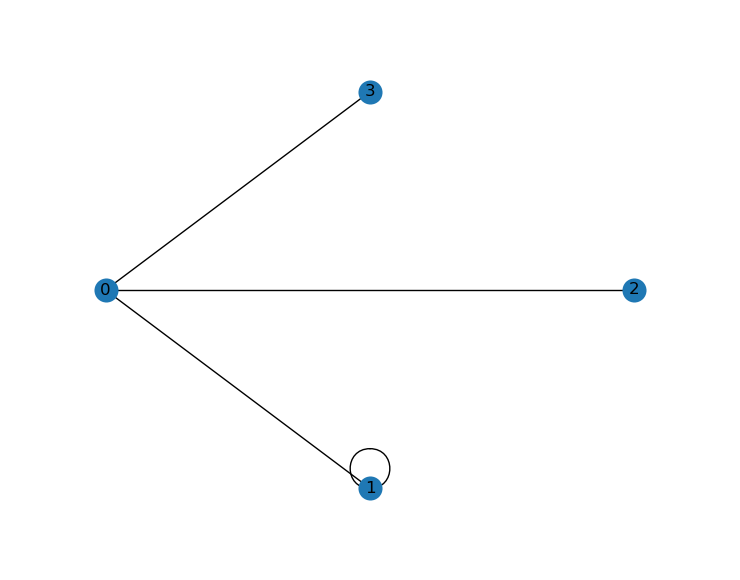

In [12]:
adjacency_dict = {0: (1, 2, 3), 1: (0, 1)}

H = nx.Graph(adjacency_dict)  # create a Graph dict mapping nodes to nbrs


nx.draw_shell(H, with_labels=True)